# Обучение GNN-модели на датасете графов

In [1]:
%load_ext autoreload
%autoreload 2

from src.data.hydrodataset import HydroDataset

import torch
torch.autograd.set_detect_anomaly(True)

from src.models.gnnstableprocessor import GNNStableProcessor
from src.visualization.visualize import visualize_graph
from src.models.train_model import HydraulicsLoss, MultiHydraulicsLoss

from torch_geometric.nn import summary
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt

In [2]:
dataset = HydroDataset(root="/tmp/hydro")
train_ds = dataset[15:]
print("Dataset length:", len(train_ds))

Dataset length: 65


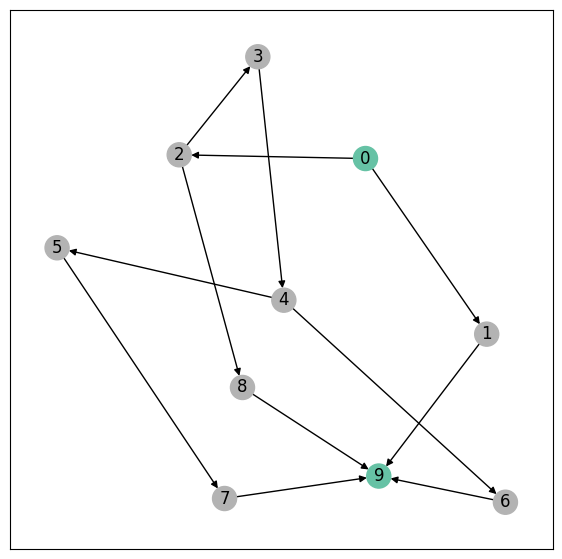

In [3]:
G = to_networkx(train_ds[1], to_undirected=False)
visualize_graph(G, color=dataset[0].x[..., 1] == 0);

In [4]:
loader = DataLoader(train_ds, batch_size=16, shuffle=True)

In [5]:
model = GNNStableProcessor(out_channels=1, 
                     num_edge_features=dataset.num_edge_features, 
                     latent_dim=64, 
                     num_convs=10, 
                     convs_hidden_layers=[64],
                     alpha_update_x=0.1,
                     aggr="mean")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

GNNStableProcessor(
  (convs): ModuleList(
    (0-9): 10 x GNNSConv(aggr=mean, latent_dim=64, alpha=0.1, hidden_layers=[64])
  )
  (final): Linear(in_features=64, out_features=1, bias=True)
  (balance_conv): BalanceConv()
  (decoders): ModuleList(
    (0-9): 10 x Linear(in_features=64, out_features=1, bias=True)
  )
)


In [6]:
criterion = MultiHydraulicsLoss(gamma=0.9)
info_criterion = HydraulicsLoss(name='Info loss')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(pretrain_data=None):
  model.train()

  total_loss = 0
  for data in loader if pretrain_data is None else [pretrain_data]:
    data = data.to(device)
    optimizer.zero_grad()
    P, _, imbalance_list = model(data)
    # imbalance_list = imbalance_list.squeeze()
    # print(f"{imbalance_list=}")
    loss = criterion(data, P, imbalance_list)

    # Вычисление информационного loss на последнем слое GNN
    info_loss = info_criterion(data, P, imbalance_list[-1, ...].unsqueeze(0))

    # total_loss += loss.item() * data.num_graphs if pretrain_data is None else loss.item()
    total_loss += info_loss.item() * data.num_graphs if pretrain_data is None else info_loss.item()

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
    optimizer.step()

  total_loss = total_loss / len(loader.dataset) if pretrain_data is None else total_loss

  return total_loss

In [7]:
# # pretrain the model
# for epoch in range(250):
#   loss = train(train_ds[0])
#   if (epoch % 10 == 0):
#     print(f'Pretraining epoch: {epoch:03d}, Loss: {loss:.4f}')   

In [8]:
# train
losses = []
for epoch in range(3500):
  loss = train()
  losses.append(loss)

  if (epoch % 10 == 0):
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}') 

Epoch: 000, Loss: 11302.1731
Epoch: 010, Loss: 818.2036
Epoch: 020, Loss: 1918.6482
Epoch: 030, Loss: 971.9166
Epoch: 040, Loss: 1826.2687
Epoch: 050, Loss: 1417.8350
Epoch: 060, Loss: 1455.8864
Epoch: 070, Loss: 1336.4641
Epoch: 080, Loss: 974.9098
Epoch: 090, Loss: 745.3803
Epoch: 100, Loss: 1092.7516
Epoch: 110, Loss: 1139.3449
Epoch: 120, Loss: 1361.0427
Epoch: 130, Loss: 912.8706
Epoch: 140, Loss: 2050.7241
Epoch: 150, Loss: 753.6294


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)
plt.title('Кривая обучения')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь')
plt.show()

# Тестирование модели

In [ ]:
edge_index = torch.tensor([
  [0, 1, 2],
  [1, 2, 3]
], dtype=torch.long)

# Структура данных атрибутов вершин графа:
# Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
x = torch.tensor([[0, 7.4], [0.0, 0], [0, 0], [0, 5.4]], dtype=torch.float32)

# Структура данных атрибутов дуг графа:
# Протяженность, км; Внутренний диаметр трубы, мм
edge_attr = torch.tensor([
  [38, 1400],
  [40, 1400],
  [43, 1400]
])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [ ]:
%%timeit
# %%timeit 
# Attention: При выводе значений давления краевые значения не выводятся, но учитываются в расчете
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')

P=tensor([[1.7250],
        [5.8743],
        [5.5691],
        [3.9446]], grad_fn=<ReluBackward0>)
flows=tensor([[[   0.0000],
         [ 152.3783],
         [ -21.8183],
         [  66.0103]],

        [[   0.0000],
         [ 157.1003],
         [  40.1104],
         [  33.5649]],

        [[   0.0000],
         [ 153.0168],
         [  56.1030],
         [  28.5373]],

        [[   0.0000],
         [ 149.8715],
         [  58.9604],
         [  36.7483]],

        [[   0.0000],
         [ 243.1919],
         [   0.0000],
         [-166.8280]],

        [[   0.0000],
         [ 153.0012],
         [  60.6186],
         [  18.1188]],

        [[   0.0000],
         [ 152.1137],
         [  57.8501],
         [  29.5415]],

        [[   0.0000],
         [ 151.6870],
         [  58.1968],
         [  30.8193]],

        [[   0.0000],
         [ 151.7664],
         [  57.9022],
         [  30.9894]],

        [[   0.0000],
         [ 150.9002],
         [  58.5722],
         [  33.457

In [ ]:
import torch_geometric
compiled = torch_geometric.compile(model)

/home/ab/anaconda3/envs/nfsolver/lib/python3.10/site-packages/torch_geometric/compile.py:28: UserWarning: Could not convert the 'model' into a jittable version. As such, 'torch.compile' may currently fail to correctly optimize your model. 'MessagePassing.jittable()' reported the following error: TorchScript support requires the definition of the types passed to `propagate()`. Please specify them via

propagate_type = {"arg1": type1, "arg2": type2, ... }

or via

# propagate_type: (arg1: type1, arg2: type2, ...)

inside the `MessagePassing` module.
  warnings.warn(JIT_WARNING.format(error=e))


In [ ]:
%%timeit
P, flows, imbalance = model(data)

330 ms ± 8.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
